<a href="https://colab.research.google.com/github/atstuyuki/ScikitLearn/blob/main/wavfile_to_spctgram_CSV_20240604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WAVファイルを一つ指定し　5つのスペクトグラム作成と周波数解析の結果をCSVに保存するコード

In [1]:
# prompt: wavフィアルをアップロードしてそのpathにfileという変数名を当てる

from google.colab import files
uploaded = files.upload()
file = list(uploaded.keys())[0]


Saving syuryo01kawamoto.wav to syuryo01kawamoto.wav


In [2]:
#音声ファイル名を確認
file

'syuryo01kawamoto.wav'

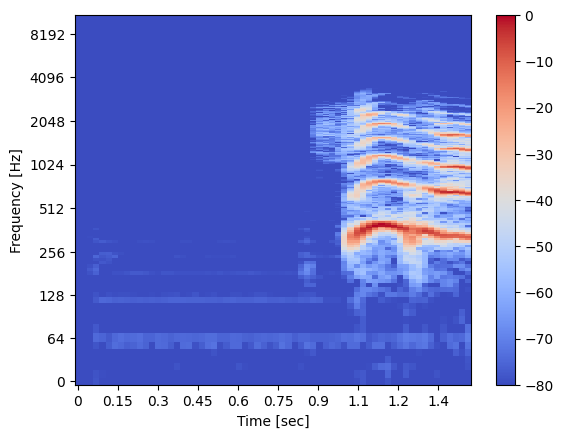

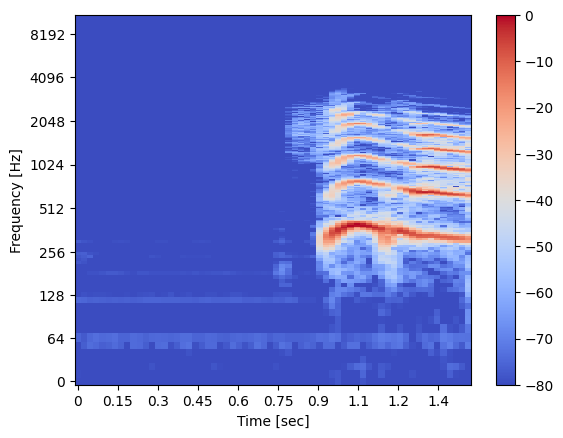

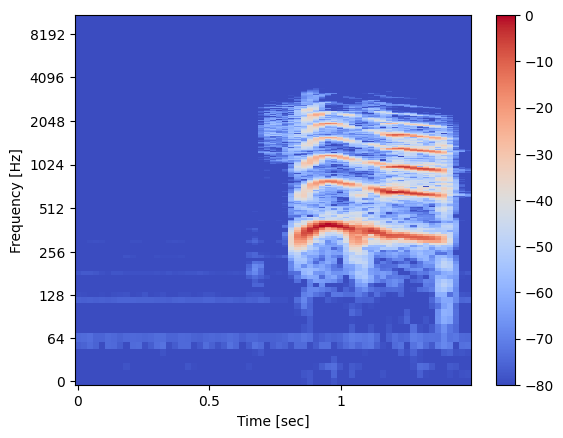

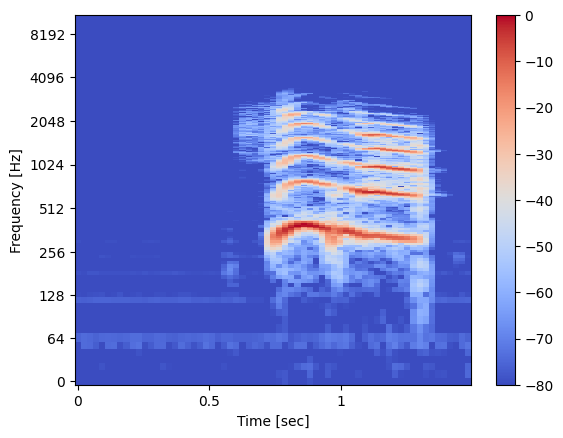

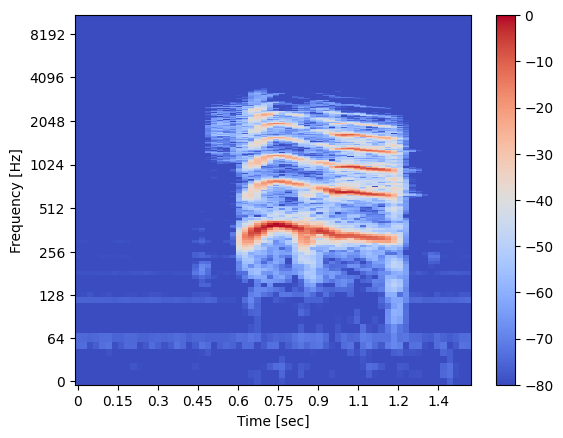

平均周波数: 870.42 Hz
中央周波数: 832.41 Hz
ZCR: 0.04
MFCC: [-546.67321797   40.65768803  -13.13139408  -16.00001137    2.61241413
   -1.03287269  -10.27341269   -5.93233811   -1.77822711   -4.58537285
   -5.17291074   -3.00919821   -3.27105427]
spectral_flatness: 0.01
spectral_centroid: 870.42


In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
import os
import csv
import numpy as np

# jpegファイルを保存するフォルダを指定する
save_folder = '/content/'  # ここに保存先のフォルダを指定してください

# CSVファイルに書き込むデータを格納するリスト
data = [['filename', 'mean_freq', 'median_freq', 'zcr', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'spectral_flatness', 'spectral_centroid']]

# WAVファイルを読み込む
y, sr = librosa.load(file)

# 2048Hzまでのローパスフィルターを適用する
sos = signal.butter(10, 2048, 'lp', fs=sr, output='sos')
y_filtered = signal.sosfilt(sos, y)

# 短時間フーリエ変換を計算する
D = librosa.stft(y_filtered)

# スペクトログラムデータをデシベルスケールに変換する
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

if save_folder:
    # ファイル名を取得する
    filename = os.path.basename(file).split('.')[0]

    # スペクトログラムの表示範囲がデータの0msから1500ms、100msから1600ms、200msから1700ms、300msから1800ms、400msから1900msのスペクトログラムを作成し、各々画像として保存する
    for start, end in [(0, 1500), (100, 1600), (200, 1700), (300, 1800), (400, 1900)]:
        plt.figure()
        ax = plt.axes()
        img = librosa.display.specshow(S_db[:, int(start/1000*sr/512):int(end/1000*sr/512)], sr=sr, x_axis='time', y_axis='log', ax=ax, cmap='coolwarm')

        # x軸、y軸、カラーバーを表示する 学習用データを作るときはここをコメントアウトする
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar(img, ax=ax)

        #軸、カラーバーを表示するときはここをコメントアウトする
        #ax.axis('off')

        # スペクトログラムをJPEG画像として保存する
        plt.savefig(f"{save_folder}/{filename}_{start}_{end}.jpeg", bbox_inches='tight', pad_inches=0)

        plt.show()

# 平均周波数と中央周波数を計算する
spectral_centroids = librosa.feature.spectral_centroid(y=y_filtered, sr=sr)[0]
mean_freq = spectral_centroids.mean()
median_freq = np.median(spectral_centroids)
#平均周波数と中央周波数をprint
print(f"平均周波数: {mean_freq:.2f} Hz")
print(f"中央周波数: {median_freq:.2f} Hz")
# ZCR（ゼロクロスレート）を計算する
zcr = librosa.feature.zero_crossing_rate(y_filtered)[0].mean()
# ZCRをprint
print(f"ZCR: {zcr:.2f}")

# MFCC（メル周波数ケプストラム係数）を計算する
n_mfcc=13 #MFCCの数を便宜上13の帯域にしている通常12～24の値で計算
mfccs = librosa.feature.mfcc(y=y_filtered, sr=sr, n_mfcc=n_mfcc)
mfccs_mean = mfccs.mean(axis=1)
# MFCCをprint
print(f"MFCC: {mfccs_mean}")

# スペクトル平坦度を計算する
spectral_flatness = librosa.feature.spectral_flatness(y=y_filtered).mean()
# spectral_flatnessをprint
print(f"spectral_flatness: {spectral_flatness:.2f}")

# スペクトル重心を計算する
spectral_centroid = librosa.feature.spectral_centroid(y=y_filtered, sr=sr)[0].mean()
# spectral_centroidをprint
print(f"spectral_centroid: {spectral_centroid:.2f}")

# CSVファイルに書き込むデータを追加する
data.append([filename, mean_freq, median_freq, zcr, *mfccs_mean, spectral_flatness, spectral_centroid])

# CSVファイルにデータを書き込む
#ファイル名は元のfile名を反映させる
with open(f"{save_folder}/{filename}_data.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerows(data)